In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


In [9]:
# read in raw data

df_wFORM = pd.read_parquet('./datasets/Results from Eneli March 2025/inference_metrics_full_train_with_form.pq')
df_noFORM = pd.read_parquet('./datasets/Results from Eneli March 2025/inference_metrics_full_train_without_form.pq')

# make timestamps in datetime format
df_wFORM['Datetime'] = pd.to_datetime(df_wFORM['time'])
df_noFORM['Datetime'] = pd.to_datetime(df_noFORM['time'])


# check to verify that the measured (i.e. "true") wind speeds don't change after training
max(df_wFORM['wspeed_true']-df_noFORM['wspeed_true'])

0.0

In [3]:
# extract data based on station ID

FOA_M14_wFORM = df_wFORM[df_wFORM['site_id'] == 111111]
FOA_M31_wFORM = df_wFORM[df_wFORM['site_id'] == 111112]
FOA_M7_wFORM  = df_wFORM[df_wFORM['site_id'] == 111113]
FOA_M54_wFORM = df_wFORM[df_wFORM['site_id'] == 111114]
Ammonit_wFORM = df_wFORM[df_wFORM['site_id'] == 210078]

FOA_M14_noFORM = df_noFORM[df_noFORM['site_id'] == 111111]
FOA_M31_noFORM = df_noFORM[df_noFORM['site_id'] == 111112]
FOA_M7_noFORM  = df_noFORM[df_noFORM['site_id'] == 111113]
FOA_M54_noFORM = df_noFORM[df_noFORM['site_id'] == 111114]
Ammonit_noFORM = df_noFORM[df_noFORM['site_id'] == 210078]


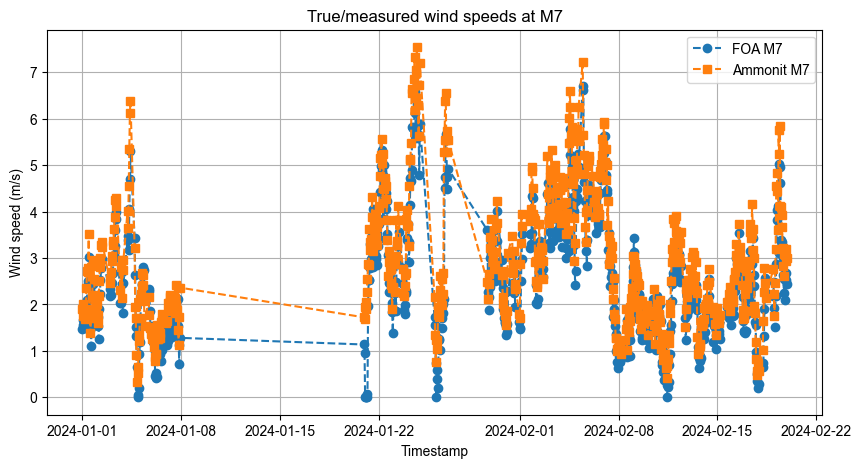

In [11]:
###
# Compare measured wind speeds between FOA_M7 and Ammonit_M7
###

# Find common timestamps
common_timestamps = set(FOA_M7_wFORM['Datetime']).intersection(set(Ammonit_wFORM['Datetime']))

FOA_M7_wFORM_common  = FOA_M7_wFORM[FOA_M7_wFORM['Datetime'].isin(common_timestamps)]
Ammonit_wFORM_common = Ammonit_wFORM[Ammonit_wFORM['Datetime'].isin(common_timestamps)]

FOA_M7_wFORM_common  = FOA_M7_wFORM_common.sort_values(by='Datetime')
Ammonit_wFORM_common = Ammonit_wFORM_common.sort_values(by='Datetime')

plt.rc('font', family='Arial')
plt.figure(figsize=(10, 5))
plt.plot(FOA_M7_wFORM_common['Datetime'], FOA_M7_wFORM_common['wspeed_true'], marker='o', linestyle='--', label='FOA M7')
plt.plot(Ammonit_wFORM_common['Datetime'], Ammonit_wFORM_common['wspeed_true'], marker='s', linestyle='--', label='Ammonit M7')
plt.xlabel('Timestamp')
plt.ylabel('Wind speed (m/s)')
plt.title('True/measured wind speeds at M7')
plt.legend()
plt.grid(True)
plt.show()

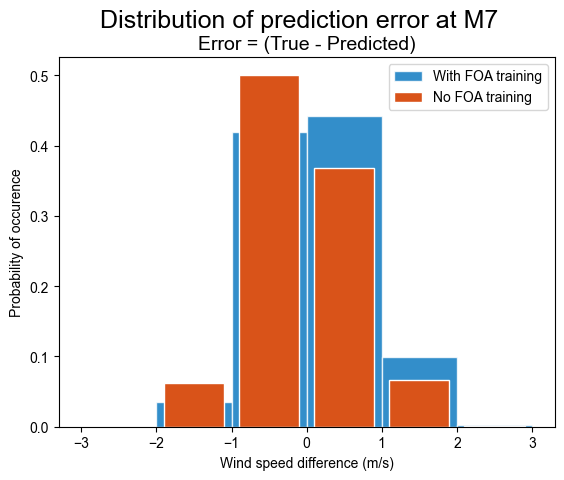

In [ ]:
# make histogram of M7 error

# define error
FOA_M7_error_wFORM = FOA_M7_wFORM['wspeed_true'] - FOA_M7_wFORM['wspeed_pred']
FOA_M7_error_noFORM = FOA_M7_noFORM['wspeed_true'] - FOA_M7_noFORM['wspeed_pred']
FOA_M7_wFORM_MAE = abs(FOA_M7_wFORM['wspeed_true'] - FOA_M7_wFORM['wspeed_pred']).mean()
FOA_M7_noFORM_MAE = abs(FOA_M7_noFORM['wspeed_true'] - FOA_M7_noFORM['wspeed_pred']).mean()

# set wind speed range bins
bin_edges = [-3, -2, -1, 0, 1, 2, 3]

# compute histogram counts
counts_wFORM, edges_wFORM = np.histogram(FOA_M7_error_wFORM, bins=bin_edges)
counts_noFORM, edges_noFORM = np.histogram(FOA_M7_error_noFORM, bins=bin_edges)
counts_wFORM = counts_wFORM / counts_wFORM.sum() 

plt.hist(FOA_M7_error_noFORM, bins=bin_edges, color=(0, 0.4470, 0.7410), edgecolor='white', density=True, alpha=0.8)
plt.bar(edges_wFORM[:-1]+0.5, counts_wFORM, width=0.8, color=(0.8500, 0.3250, 0.0980), edgecolor='white')
# plt.hist(FOA_M7_error_noFORM, bins=bin_edges, color=(0.8500, 0.3250, 0.0980))

# FOA_M7_error_wFORM.hist(bins=bin_edges, alpha=0.85, color=(0, 0.4470, 0.7410))
# FOA_M7_error_noFORM.hist(bins=bin_edges, alpha=0.5, color=(0.8500, 0.3250, 0.0980))

# Add a title and labels
plt.rcParams["font.family"] = "Arial"
plt.suptitle('Distribution of prediction error at M7', fontsize=18)
plt.title('Error = (True - Predicted)', fontsize=14)
plt.xlabel('Wind speed difference (m/s)')
plt.ylabel('Probability of occurence')
plt.legend(('With FOA training', 'No FOA training'))

# Show the plot
plt.show()